In [1]:
### import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

## Training of GNN model (loss vs iteration)

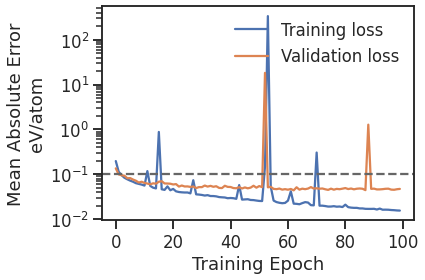

In [3]:
log = pd.read_csv('outputs/icsd_zintl_relaxed/trained_model_icsd_zintl/log.csv')

plt.semilogy(log.epoch, log.loss, label='Training loss')
plt.semilogy(log.epoch, log.val_loss, label='Validation loss')
plt.axhline(.1, ls='--', color='.4')
plt.legend()
# plt.ylim([0.05, 0.2])

plt.ylabel('Mean Absolute Error\neV/atom')
plt.xlabel('Training Epoch')
plt.tight_layout()
# plt.savefig('figs/training_curve.svg')

## Load the model and preprocessor

In [42]:
import pickle
import tensorflow as tf
import nfp
from nfp_extensions import RBFExpansion, CifPreprocessor

# Initialize the preprocessor class.
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json('tfrecords2/preprocessor.json')
    
model = tf.keras.models.load_model(
    'trained_model2/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

## Load the test data and convert to model inputs (using pymatgen)

In [43]:
from pymatgen.core.structure import Structure
from tqdm import tqdm

In [44]:
test = pd.read_csv('tfrecords2/test.csv.gz')

cif_file = lambda x: '/scratch/pstjohn/utf8_cifs/icsd_{:06d}.cif'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

Example crystal parsing

In [45]:
get_crystal(test.icsdnum.iloc[1])

Structure Summary
Lattice
    abc : 6.1017 6.2504 7.452167877872854
 angles : 114.79468686451068 103.41334283277807 90.0
 volume : 249.4459374521661
      A : 0.0 0.0 -6.1017
      B : -1.005140980953885e-15 -6.2504 -3.827266176695308e-16
      C : -6.540602754873803 3.1252 1.7287124234346232
PeriodicSite: C4+ (-4.5392, 1.4132, -4.2235) [0.8888, 0.1209, 0.6940]
PeriodicSite: C4+ (-2.0014, -1.7120, -3.2004) [0.6112, 0.4269, 0.3060]
PeriodicSite: C4+ (-2.0014, -4.5384, -0.1495) [0.1112, 0.8791, 0.3060]
PeriodicSite: C4+ (-4.5392, -1.4132, -1.1726) [0.3888, 0.5731, 0.6940]
PeriodicSite: La3+ (-5.2231, 1.7849, -1.2102) [0.4246, 0.1137, 0.7986]
PeriodicSite: La3+ (-1.3175, -1.3403, -0.1120) [0.0754, 0.3151, 0.2014]
PeriodicSite: La3+ (-1.3175, -4.9101, -3.1628) [0.5754, 0.8863, 0.2014]
PeriodicSite: La3+ (-5.2231, -1.7849, -4.2610) [0.9246, 0.6849, 0.7986]
PeriodicSite: N3- (-2.7274, 0.9857, -0.8210) [0.2527, 0.0508, 0.4170]
PeriodicSite: N3- (-3.8132, -2.1395, -0.5011) [0.2473, 0.6338, 0.5

Create a tf.data pipeline

In [46]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(get_crystal(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

## Predict the test crystals.
The slow step here is definitely loading the CIF files and creating the primitive cell

In [47]:
predictions = model.predict(test_dataset)

  2%|▏         | 10/500 [00:01<02:05,  3.91it/s]/projects/rlmolecule/pstjohn/envs/tf2_pymatgen/lib/python3.7/site-packages/pymatgen/io/cif.py:1122: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


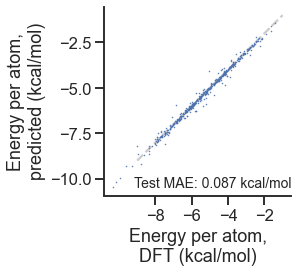

In [48]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(test.energyperatom, predictions, '.', ms=1)
ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
ax.set_xticks([-2, -4, -6, -8])
plt.ylabel('Energy per atom,\npredicted (eV/atom)')
plt.xlabel('Energy per atom,\nDFT (eV/atom)')
plt.tight_layout()

ax.text(1., 0.025, f'Test MAE: {(test.energyperatom - predictions.squeeze()).abs().mean():.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

sns.despine(trim=False)
plt.savefig('figs/test_parity.svg')

In [51]:
test['predicted_energyperatom'] = predictions

In [54]:
test.to_csv('trained_model2/predicted.csv', index=False)

Looks like we can speed up evaluation at test-time by not creating the primitive crystal. And good to validate that the predictions are (almost) identical between the two methods. Note, this changes the underlying graph structure as well

In [ ]:
get_crystal_no_primitive = lambda x: Structure.from_file(cif_file(x), primitive=False)
test_dataset_no_primitive = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(
        get_crystal_no_primitive(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

predictions_no_primitive = model.predict(test_dataset_no_primitive)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax = plt.plot(predictions, predictions_no_primitive, '.', ms=1)

Might be worth looking into why we're not getting perfect predictions for these

In [ ]:
test['prim_err'] = np.abs(predictions_no_primitive - predictions)
test.sort_values('prim_err', ascending=False).head(10)